## Домашнее задание

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать обзорный анализ выбранного датасета
2. сделать feature engineering
3. обучить любой классификатор (какой вам нравится)
3. разобраться с SHAP и построить важности признаков для:
   * всего тестового набора данных (summary_plot - дать интерпретацию)для топ 10%    
   * для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

Source data https://archive.ics.uci.edu/ml/datasets/Breast+Cancer

In [111]:
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

import xgboost as xgb

In [98]:
df = pd.read_csv('./Data/breast-cancer.data', names=['Class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat'])
df.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


Attribute Information:
1. Class: no-recurrence-events, recurrence-events
2. age: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99.
3. menopause: lt40, ge40, premeno.
4. tumor-size: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44,
              45-49, 50-54, 55-59.
5. inv-nodes: 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26,
             27-29, 30-32, 33-35, 36-39.
6. node-caps: yes, no.
7. deg-malig: 1, 2, 3.
8. breast: left, right.
9. breast-quad: left-up, left-low, right-up,	right-low, central.
10. irradiat:	yes, no.



In [99]:
df.describe(include='all',).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Class,286,2,no-recurrence-events,201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,286,6,50-59,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN
menopause,286,3,premeno,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tumor-size,286,11,30-34,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
inv-nodes,286,7,0-2,213,NaN,NaN,NaN,NaN,NaN,NaN,NaN
node-caps,286,3,no,222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deg-malig,286.0,NaN,NaN,NaN,2.048951,0.738217,1.0,2.0,2.0,3.0,3.0
breast,286,2,left,152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
breast-quad,286,6,left_low,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN
irradiat,286,2,no,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Заменим поля 'age', 'tumor-size' и 'inv-nodes' на числовые значения

In [100]:
def first_num(source_str):
#     source_str = row[field]
    return int(re.search(r'\d+', source_str).group(0))

In [101]:
for f in ['age', 'tumor-size', 'inv-nodes']:
    df[f] = df[f].apply(first_num)

In [102]:
df.describe(include='all',).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Class,286,2,no-recurrence-events,201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,286.0,NaN,NaN,NaN,46.643357,10.118183,20.0,40.0,50.0,50.0,70.0
menopause,286,3,premeno,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tumor-size,286.0,NaN,NaN,NaN,24.405594,10.529649,0.0,20.0,25.0,30.0,50.0
inv-nodes,286.0,NaN,NaN,NaN,1.573427,3.451904,0.0,0.0,0.0,3.0,24.0
node-caps,286,3,no,222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deg-malig,286.0,NaN,NaN,NaN,2.048951,0.738217,1.0,2.0,2.0,3.0,3.0
breast,286,2,left,152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
breast-quad,286,6,left_low,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN
irradiat,286,2,no,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
df.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30,premeno,30,0,no,3,left,left_low,no
1,no-recurrence-events,40,premeno,20,0,no,2,right,right_up,no
2,no-recurrence-events,40,premeno,20,0,no,2,left,left_low,no
3,no-recurrence-events,60,ge40,15,0,no,2,right,left_up,no
4,no-recurrence-events,40,premeno,0,0,no,2,right,right_low,no


на оставшихся проведем обычный one-hot-encoding

In [105]:
y_data = df['Class']
x_data = pd.get_dummies(df.drop('Class', axis=1))

## Обучим классификатор

In [108]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, shuffle=True)
model = xgb.XGBClassifier()

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

### Посмотрим важность признаков

<BarContainer object of 20 artists>

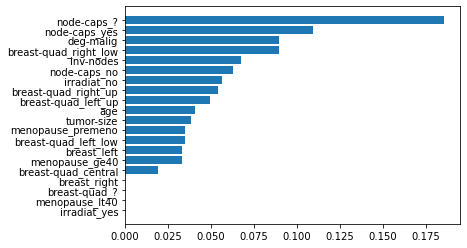

In [114]:
sorted_idx = model.feature_importances_.argsort()

plt.barh(x_data.columns[sorted_idx], model.feature_importances_[sorted_idx])

In [ ]:
model.